# Prompt-Based NLP

In Homework 4, we’ll try using Jigsaw’s Toxic Language dataset using PET to train our classifier.
Conveniently the PET authors have already provided code for you to use at https://github.com/timoschick/pet. Your task will be to (1) write your own custom verbalizer and patterns
and (2) train your model by modifying one of their example scripts. The PET repository has good
documentation on how to set up their model, train it, and use the code.

Like in Homework 3, in this assignment we will use a much smaller but nearly-as-performant
version of BERT, https://huggingface.co/microsoft/MiniLM-L12-H384-uncased,
to train our models. While PET can work on any LLM, MiniLM will make the homework much
faster to finish.

In [1]:
import pandas as pd
from sklearn.metrics import f1_score
import numpy as np
from transformers import BertTokenizerFast, BertForSequenceClassification
from datasets import load_dataset, load_metric, Dataset
from transformers import Trainer, TrainingArguments
import torch
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv('data/hw4_train.csv')
test_df = pd.read_csv('data/hw4_test.csv')
print(train_df.shape)
train_df.sample(5)

(159571, 3)


,id,comment_text,toxic
51660,8a2ecd9d27057deb,"""\n\nYou're welcome, and congratulations! (tal...",0
31467,538df12bda6c90aa,"""\n\n aftermath ww2 \n\nThanks your suggestion...",0
1209,0343c2282ed74811,Abuse of your admin powers \n\nBeing discrimin...,0
32865,576e3ee35b5953bd,US claims it has rightful access to data store...,0
75036,c8c7848a18e4618d,Elliskev! \n\nElliskev! You tried to block me!...,0


In [3]:
# create unlabeled data and dev data

train_unlabled_df = train_df.drop('toxic', axis=1)
train_unlabled_df.to_csv('data/hw4_train_unlabled.csv', index=False)

dev_split_pcent = .2
dev_split_size = round(train_df.shape[0] * .2)
dev_df = train_df.sample(dev_split_size).copy()
dev_df.to_csv('data/hw4_dev.csv', index=False)

## Part 1

Write a simple piece code that takes a single word as input and then
tokenizes it with the BERT tokenizer in huggingface and returns the word’s corresponding tokens
(or token IDs) in the BERT vocabulary. You’ll want to use this piece of code in the next task to
check that your verbalizer is using only single-token words.

In [7]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [8]:
def check_verbalizers_oneword(string_list):
    """
    accepts a string and tokenizes it using a predefined tokenizer (such as BertTokenizer)
    checks to see if the length of the list of tokens is one
    if the token list is greater than 1, it is dropped
    otherwise, it is added to a new list
    returns a new string which will be split into single word tokens
    """
    oneword_tokens = []
    start_len = len(string_list)
    for word in string_list:
        token = tokenizer.tokenize(word)
        if len(token) == 1:
            oneword_tokens.append(token[0])
    end_len = len(oneword_tokens)
    if start_len != end_len:
        print("removed multi-word tokens")
    else:
        print("no multi-word tokens present")

    return oneword_tokens

In [9]:
VERBALIZER = {
    "0": [
        "awesome", "fast", # pattern_id == 0
        "helpful", "clear", # pattern_id == 1
        "figure", "find", # pattern_id == 2
        "post", "edit", # pattern_id == 3
        "expert", "friend", # pattern_id == 4
        "citation", "better", # pattern_id == 5
        "think", "believe", # pattern_id == 6
        "act", "achieve", # pattern_id == 7
        "aware", "sure", # pattern_id == 8
        "edit", "contribute", # pattern_id == 9
        ],
    "1": [
        "stupid", "horrible", # pattern_id == 0
        "ashamed", "fired", # pattern_id == 1
        "jump", "die", # pattern_id == 2
        "garbage", "nonsense", # pattern_id == 3
        "bitch", "baby", # pattern_id == 4
        "life", "job", # pattern_id == 5
        "are", "cannot", # pattern_id == 6
        "threaten", "block", # pattern_id == 7
        "sick", "tired", # pattern_id == 8
        "destroy", "troll", # pattern_id == 9 #vandalize not accepted
        ]
}

In [10]:
for label, verbal_list in VERBALIZER.items():
    print(f"label = {label}")
    new_verbals = check_verbalizers_oneword(verbal_list)

label = 0
no multi-word tokens present
label = 1
no multi-word tokens present


## Part 2

Write 10 different prompts that can be used to classify toxic speech.
Prompts should be relatively different (not just adding/changing one word). For each, come up
with at least 2 verbalizations of each class (toxic/non-toxic). You can share verbalizations across
prompts if needed. We really want to see some creativity across your prompts (this will also help
the model learn more too).

### Initialize MyTaskDataProcessor and MyTaskPVP

Both are necessary for completing a Task

Initialized inside `pet/tasks.py` and `pet/pvp.py`

## Part 3
For comparison with PET, train a regular classifier using Trainer and
the MiniLM parameters on all the training data (very similar to what you did in Homework 3!). You
should train your model for at least two epochs, but you’re not required to do any hyperparameter
tuning (you just need a score). Predict the toxicity of the provided test data and calculate the F1.

*Model was trained in a separate notebook - see `model-training.ipynb` for details*

In [11]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
trained_model = BertForSequenceClassification.from_pretrained('MiniLMmodel', num_labels=2)
# f1 ~ 0.81224

In [10]:
train_dataset = Dataset.from_pandas(train_df.rename(columns={'toxic':'labels'}))
test_dataset = Dataset.from_pandas(test_df.rename(columns={'toxic':'labels'}))

In [47]:
tokenized_train_dataset = train_dataset.map(lambda x: tokenizer(x['comment_text'],padding = 'max_length', max_length =512, truncation=True))
tokenized_test_dataset = test_dataset.map(lambda x: tokenizer(x['comment_text'],padding = 'max_length', max_length =512, truncation=True))

  0%|          | 0/159571 [00:00<?, ?ex/s]

  0%|          | 0/63978 [00:00<?, ?ex/s]

In [48]:
tokenized_train_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask','labels'])
tokenized_test_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [49]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1) # for whole numbers
    preds = preds.reshape(len(preds),)
    f1 = f1_score(labels, preds, average='macro')
    return {
        'f1': f1
    }

In [50]:
training_args = TrainingArguments(
    output_dir = 'MiniLM_trained',
    num_train_epochs = 2,
    learning_rate=1e-4,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 16,
    gradient_accumulation_steps = 16,
)

In [51]:
trainer = Trainer(
    trained_model,
    training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s-ryanlee (use `wandb login --relogin` to force relogin)


In [52]:
trained_model_eval = trainer.evaluate()

Evaluation:   0%|          | 0/2000 [00:00<?, ?it/s]

/home/sryanlee/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.19436033427715302,
 'eval_f1': 0.8122410868096552,
 '_timestamp': 1650262037,
 '_runtime': 209}

## Part 4
Using your patterns and verbalizers, train separate PET models on 10,
50, 100, and 500 instances of data. Your data should be randomly sampled from the training data
but be sure to have examples of each class. You are free to choose which instances you use and
what distribution of toxic/non-toxic labels are in your training data (provided you have at least one
example of each). For each model, predict the scores for the provided test data and calculate the
Macro F1.

### Sample data for each PET instance

In [12]:
train_df.groupby('toxic').size()

toxic
0    144277
1     15294
dtype: int64

In [13]:
instances = [10, 50, 100, 500]
if os.path.exists('data/instances') == True:
    for instance in instances:
        if os.path.exists('data/instances/instance'+str(instance)+'/hw4_train.csv') == False:
            instance_train = train_df.groupby('toxic').sample(instance)
            instance_train = instance_train[['toxic', 'comment_text', 'id']]
            instance_train.to_csv('data/instances/'+'instance'+str(instance)+'/hw4_train.csv', index=False, header=False)
        if os.path.exists('data/instances/instance'+str(instance)+'/hw4_train_unlabeled.csv') == False:
            instance_train_unlabeled = train_unlabled_df.sample(instance)
            instance_train_unlabeled = instance_train_unlabeled[['comment_text', 'id']]
            instance_train_unlabled.to_csv('data/instances/'+'instance'+str(instance)+'/hw4_train_unlabeled.csv', index=False, header=False)
        if os.path.exists('data/instances/instance'+str(instance)+'/hw4_dev.csv') == False:
            instance_dev = train_df.groupby('toxic').sample(instance)
            instance_dev = instance_dev[['toxic', 'comment_text', 'id']]
            instance_dev.to_csv('data/instances/'+'instance'+str(instance)+'/hw4_dev.csv', index=False, header=False)
        if os.path.exists('data/instances/instance'+str(instance)+'/hw4_test.csv') == False:
            instance_test = test_df.groupby('toxic').sample(instance)
            instance_test = instance_test[['toxic', 'comment_text', 'id']]
            instance_test.to_csv('data/instances/'+'instance'+str(instance)+'/hw4_test.csv', index=False, header=False)
else:
    print("create instance data directory")

### Train a PET model for each pattern id in the ToxicPVP

Models were trained on the command line using the following arguments

for each pattern_id in pattern_ids [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

`python3 cli.py 
--method pet 
--pattern_ids 0 
--data_dir data/instances/instance10 \ ## [10, 50, 100, 500]
--model_type bert \ 
--model_name_or_path microsoft/MiniLM-L12-H384-uncased \ 
--task_name toxic \ 
--output_dir pet_output/instance10-0 \ ## [10-0, 10-1, 10-2,...etc for each instance 50, 100, 500]
--do_train 
--do_eval`

## Part 5
Let’s compare our PET-based models and our regular all-data MiniLM
model. Plot the score for each PET model and your full-data MiniLM model using Seaborn. If
you are feeling curious, feel free to train models on different sizes/distributions of data and include
those too. Write your guess on how many instances you think you need to train a PET model that
will reach the performance of a MiniLM model trained on all the data.

In [31]:
pattern_ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
MODEL_SCORES = {
    'instance10': {},
    'instance50': {},
    'instance100': {},
    'instance500': {}
}
for instance in instances:
    instance_name = 'instance'+str(instance)
    instance_path = os.path.join('pet_output', instance_name)
    if os.path.exists(instance_path):
        for id_num in pattern_ids:
            pattern_path = os.path.join(instance_path,instance_name+'-'+str(id_num))
            filename = 'result_test.txt'
            filepath = os.path.join(pattern_path,filename)
            with open(os.path.join(filepath), 'r') as infile:
                for line in infile.readlines():
                    score_name = 'f1-macro-p'+str(id_num)
                    if score_name in line:
                        result = line.split()
                        score = result[1]
                        #print(id_num, score)
                        MODEL_SCORES[instance_name][id_num] = score
model_scores_json = json.dumps(MODEL_SCORES)
with open('final_results/model_scores.json', 'w') as outfile:
    outfile.write(model_scores_json)

In [32]:
scores_df = pd.DataFrame.from_dict(MODEL_SCORES).reset_index().rename(columns={"index":"pattern_id"})
scores_df['miniLM'] = 0.8122410868096552

In [33]:
scores_df

,pattern_id,instance10,instance50,instance100,instance500,miniLM
0,0,0.6272130647130647,0.7493190526302445,0.8294244282002536,0.9092681003737988,0.812241
1,1,0.6431185449988742,0.8490695207724716,0.8347084874349099,0.8963105442694415,0.812241
2,2,0.5722795722795723,0.7561214982399468,0.7699299741898961,0.8966630851467093,0.812241
3,3,0.5308501137902226,0.7413206671004836,0.8128772775158374,0.8926553197344363,0.812241
4,4,0.6331176638082008,0.8825443129839343,0.8362207202391682,0.9026530053285485,0.812241
5,5,0.5412970093276999,0.6525075842768031,0.7657613918443127,0.8919448998769037,0.812241
6,6,0.6152895058158216,0.7510072527107237,0.8261722017389961,0.9036488973892801,0.812241
7,7,0.5520050125313283,0.8026704489361608,0.8149583508193083,0.8946345958737201,0.812241
8,8,0.47191697191697196,0.6946263867232959,0.7930913505574974,0.8996332389836206,0.812241
9,9,0.6402597402597402,0.8252660722925306,0.803086936069469,0.8926559335480123,0.812241


In [34]:
pet_results = []
for instance in instances:
    score_name = 'instance'+str(instance)
    model_type = "pet_"+score_name
    print(model_type)
    results = pd.DataFrame()
    results["model_type"] = model_type
    results["f1_score"] = scores_df[score_name].astype(float)
    results["pattern_id"] = scores_df.pattern_id
    results.model_type.fillna(model_type, inplace=True)
    pet_results.append(results)

pet_instance10
pet_instance50
pet_instance100
pet_instance500


In [35]:
results_df = pd.concat(pet_results, axis=0)
#results_df.model_type.fillna('pet', inplace=True)
results_df

,model_type,f1_score,pattern_id
0,pet_instance10,0.627213,0
1,pet_instance10,0.643119,1
2,pet_instance10,0.572280,2
3,pet_instance10,0.530850,3
4,pet_instance10,0.633118,4
5,pet_instance10,0.541297,5
6,pet_instance10,0.615290,6
7,pet_instance10,0.552005,7
8,pet_instance10,0.471917,8
9,pet_instance10,0.640260,9


In [36]:
df2 = {'model_type': 'miniLM', 'f1_score': 0.8122410868096552, 'pattern_id': 0}
df2 = pd.DataFrame(df2, index=[0])
results_df = pd.concat([results_df, df2], axis=0, ignore_index=True)
results_df

,model_type,f1_score,pattern_id
0,pet_instance10,0.627213,0
1,pet_instance10,0.643119,1
2,pet_instance10,0.572280,2
3,pet_instance10,0.530850,3
4,pet_instance10,0.633118,4
5,pet_instance10,0.541297,5
6,pet_instance10,0.615290,6
7,pet_instance10,0.552005,7
8,pet_instance10,0.471917,8
9,pet_instance10,0.640260,9


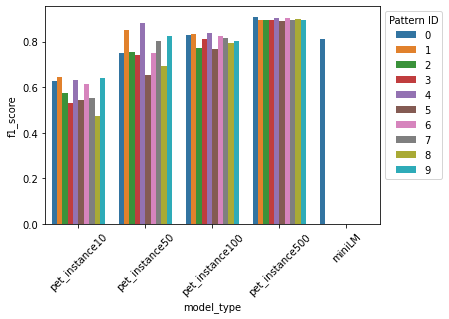

<Figure size 288x432 with 0 Axes>

In [40]:
test_plot = results_df[results_df.f1_score.isna() == False]
sns.barplot(data=test_plot, x='model_type', y='f1_score', hue='pattern_id')
plt.legend(bbox_to_anchor=(1, 1), title='Pattern ID')
plt.xticks(rotation = 45) 
plt.figure(figsize=(4,6))
plt.savefig('compare_model_scores.png')